In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357254 sha256=f910922c2d372e4e1301143f2e7770f7d52d3619f353991c7f70e8b8a3ce1ec1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [5]:
from surprise import Dataset, Reader, SVD

In [6]:
ratings = pd.read_csv('/content/ratings_small.csv')
movies = pd.read_csv('/content/movies_metadata.csv', low_memory=False)

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [8]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [9]:
movies = movies[['id', 'title']]
movies.columns = ['movieId', 'title']
movies['movieId'] = pd.to_numeric(movies['movieId'], errors='coerce')
movies = movies.dropna().reset_index(drop=True)
ratings = ratings[ratings['movieId'].isin(movies['movieId'].unique())]

In [10]:
data = pd.merge(ratings, movies, on='movieId')


<ipython-input-11-f270cd6df2cb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating",data=ratings,palette="tab10")


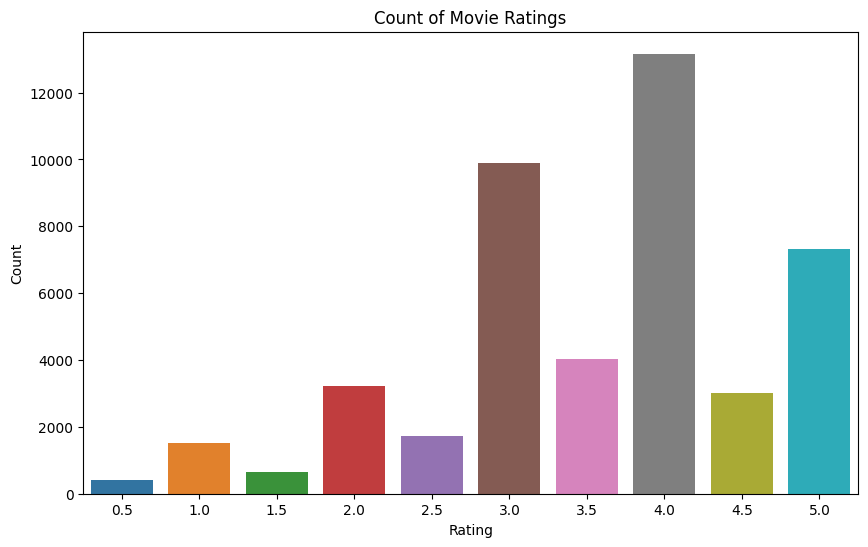

In [11]:
plt.figure(figsize=(10, 6))

sns.countplot(x="rating",data=ratings,palette="tab10")
plt.title('Count of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

<ipython-input-12-b74809616c29>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='viridis')


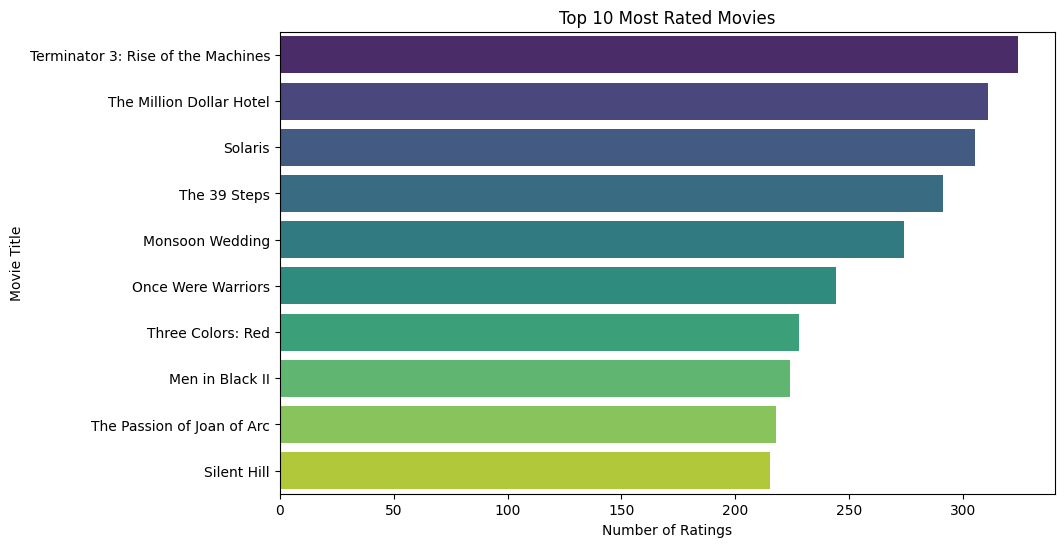

In [12]:
top_10_movies = data['title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()

In [13]:
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [14]:
trainset = data_surprise.build_full_trainset()
svd = SVD()
svd.fit(trainset)

In [15]:
testset = trainset.build_testset()

In [16]:
predictions = svd.test(testset)

In [17]:
pred_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'actual', 'predicted', 'details'])

In [18]:
pred_df['actual_rounded'] = pred_df['actual'].round()
pred_df['predicted_rounded'] = pred_df['predicted'].round()

In [19]:
accuracy = accuracy_score(pred_df['actual_rounded'], pred_df['predicted_rounded'])
precision = precision_score(pred_df['actual_rounded'], pred_df['predicted_rounded'], average='weighted', zero_division=0)
recall = recall_score(pred_df['actual_rounded'], pred_df['predicted_rounded'], average='weighted', zero_division=0)
f1 = f1_score(pred_df['actual_rounded'], pred_df['predicted_rounded'], average='weighted', zero_division=0)

In [20]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.5620485007446264


In [21]:
print(f"Precision: {precision}")

Precision: 0.5905716051940898


In [22]:
print(f"Recall: {recall}")

Recall: 0.5620485007446264


In [23]:
print(f"F1 Score: {f1}")

F1 Score: 0.5339740077550019


In [24]:
conf_matrix = confusion_matrix(pred_df['actual_rounded'], pred_df['predicted_rounded'])

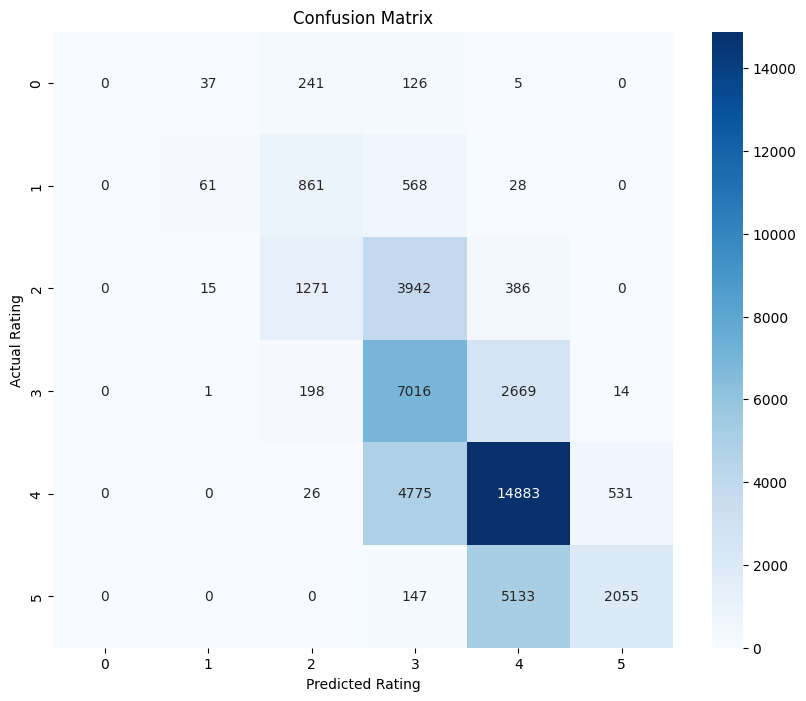

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.show()

<ipython-input-26-d3d12f5859ba>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


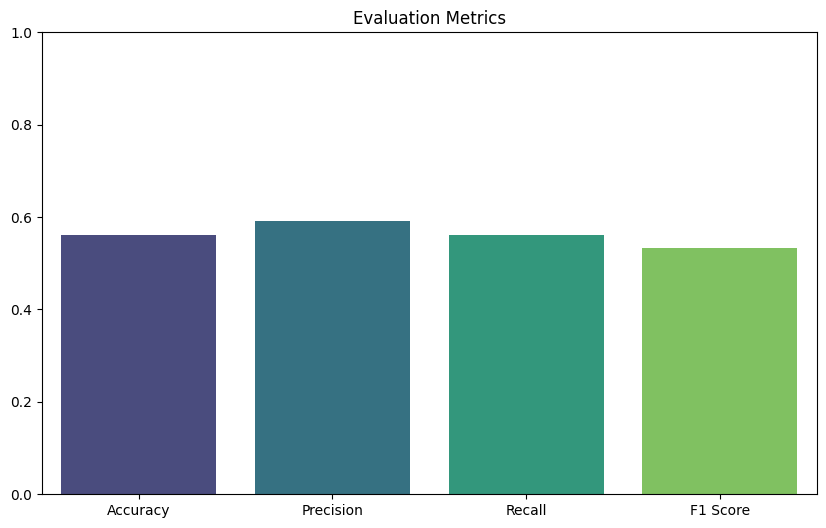

In [26]:
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title('Evaluation Metrics')
plt.ylim(0, 1)
plt.show()


In [27]:
import matplotlib.pyplot as plt

<ipython-input-29-e427877227d1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="predicted_rounded",data=pred_df,palette="tab10")


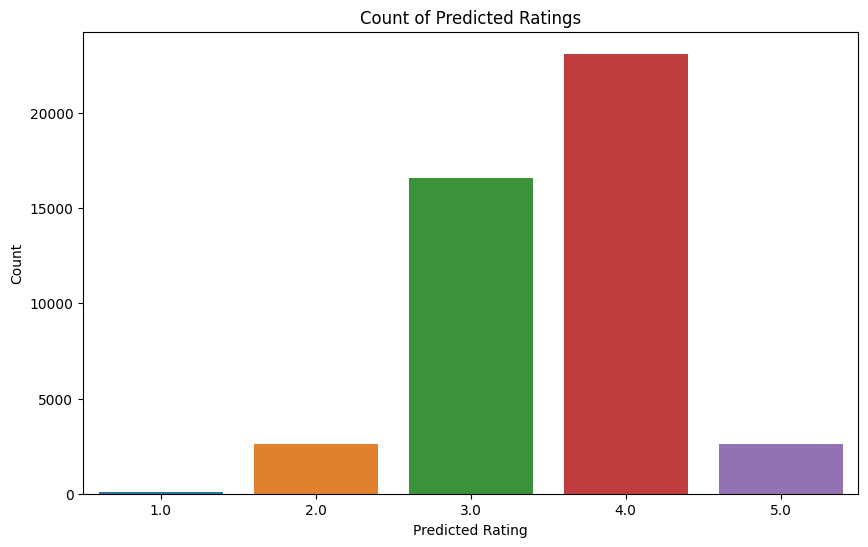

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x="predicted_rounded",data=pred_df,palette="tab10")
plt.title('Count of Predicted Ratings')
plt.xlabel('Predicted Rating')
plt.ylabel('Count')
plt.show()